# MNIST Baselines: Dropout

In [3]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils as np_utils
from sklearn import metrics
from sklearn.cross_validation import train_test_split
import numpy as np

# choose GPUs
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# custom libraries
# meta-Parameters
#base_dir = '/Users/cyrilwendl/Documents/EPFL'  # for local machine
base_dir = '/raid/home/cwendl'  # for guanabana
import sys
sys.path.append(base_dir + '/SIE-Master/Zurich') # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package

# import libraries
from baselines.helpers import *
from baselines.plots import *
from helpers.data_augment import *
from helpers.helpers import *
from helpers.plots import *

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6287214563864317332
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 340197376
locality {
  bus_id: 1
}
incarnation: 9407949535831214009
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


# Data Import 
Import the data, delete all data in the training set of class 7


In [4]:
# adapted from Source: https://github.com/keras-team/keras/tree/master/examples

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test_all, y_test_all) = mnist.load_data()
print(np.unique(y_train, return_counts=True))

label_to_remove = 7

# remove all trainig samples containing a label label_to_remove
x_train = x_train[y_train!=label_to_remove]
y_train = y_train[y_train!=label_to_remove]
    
x_test = x_test_all[y_test_all!=label_to_remove]
y_test = y_test_all[y_test_all!=label_to_remove]

# decrease all labels that are higher by -1 to avoid gaps
for i in range(label_to_remove+1, 11):
    y_train[y_train == i] = (i-1)
    y_test[y_test == i] = (i-1)
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 5851, 5949]))


In [5]:
batch_size = 128
num_classes = 9
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

# Reshape for Tensorflow
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_test_all = x_test_all.reshape(x_test_all.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_test_all = x_test_all.astype('float32')
x_train /= 255
x_test /= 255
x_test_all /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.np_utils.to_categorical(y_test, num_classes)

x_train shape: (53735, 28, 28, 1)
53735 train samples
8972 test samples


In [6]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print(model.summary())

model_train = False;
if model_train:
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
    model.save('../mnist-weights.h5')
else :
    model = load_model('../mnist-weights.h5')

#score = model.evaluate(x_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [7]:
y_pred = model.predict(x_test_all)
y_pred_label = np.argmax(y_pred, axis = 1);

for i in np.flip(range(label_to_remove,9),axis=0):
    y_pred_label[y_pred_label == i] = (i+1)

In [8]:
print(metrics.classification_report(y_pred_label,y_test_all))

             precision    recall  f1-score   support

          0       0.99      0.97      0.98      1001
          1       1.00      0.95      0.98      1190
          2       0.99      0.85      0.91      1211
          3       0.99      0.87      0.93      1156
          4       0.99      0.97      0.98      1006
          5       0.99      0.98      0.99       899
          6       0.99      0.99      0.99       955
          7       0.00      0.00      0.00         0
          8       0.99      0.98      0.99       982
          9       0.98      0.62      0.76      1600

avg / total       0.99      0.89      0.93     10000



/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Baseline Method
## Confidence from Invariance to Image Transformations
https://arxiv.org/pdf/1804.00657.pdf

In [9]:
# function to implement prediction with dropout
y_preds = predict_with_dropouts_batch(model, x_test_all, 
                                      batch_size=100, n_iter=100)

100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


In [10]:
# get mean softmax output
y_pred_c = np.mean(y_preds,axis=0)

### Mean Scores

Av. certainty in unseen class:0.70


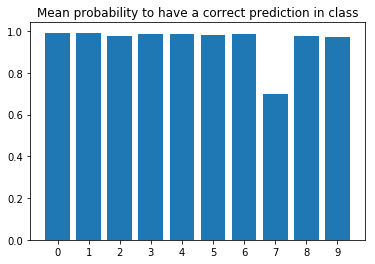

In [11]:
# mean accuracy per class
proba_correct = np.max(y_pred_c, axis=-1) # probability to have a correct prediction

av_p = [np.mean(proba_correct[y_test_all==i]) for i in 
        range(10)]


plt.bar(range(10), av_p)
plt.xticks(range(10))
plt.title("Mean probability to have a correct prediction in class")
print("Av. certainty in unseen class:%.2f"%av_p[label_to_remove])

Mean accuracy: 97.32 %
Std accuracy: 9.44 %
Av. certainty in unseen class:0.80


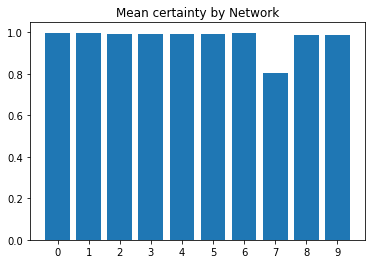

In [12]:
# for comparison: MSR by network
y_pred = model.predict(x_test_all)

c = np.max(y_pred, axis=-1)
    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: %.2f %%" % (pred_acc_mean*100) )
print("Std accuracy: %.2f %%" % (pred_acc_std*100) )

# get mean proba in all 
av_p = [np.mean(c[y_test_all==i]) for i in range(10)]

plt.bar(range(10), av_p)
plt.xticks(range(10))
plt.title("Mean certainty by Network")

print("Av. certainty in unseen class:%.2f"%av_p[label_to_remove])

### Precision-Recall Curve

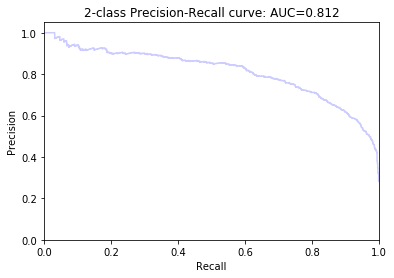

In [13]:
# probability
y_scores = 1 - proba_correct
y_true = (y_pred_label != y_test_all)*1
precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_scores)
plot_precision_recall(precision, recall)